# set path

In [17]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)

    #unpack zipped file (reading files from drive is slow)
    os.chdir('/content')
    import shutil
    shutil.unpack_archive("/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess.zip", "./")
    rootpath = '/content/freya_postprocess/'

except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'


# Imports

In [18]:
import torch

In [19]:
import torchvision

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle('/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)



# Data loaders and transformers

In [21]:
mass_bins = np.linspace(11, 14.7, 11) ## number of classes = len(mass_bins) - 1 = 10
mass_bins_nums = np.histogram(subhalos_df['logSubhaloMass'], bins=mass_bins)[0]
mass_bins_weights = np.max(mass_bins_nums)/mass_bins_nums
mass_bins_weights = mass_bins_weights / np.sum(mass_bins_weights)
mass_bins_weights = torch.tensor(mass_bins_weights, dtype=torch.float32)

class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)  # Define mass_bins globally or pass as argument

    def __init__(self, root_dir, subhalos_df, load_3d=False):
        self.root_dir = root_dir
        self.subhalos_df = subhalos_df
        self.files = glob(root_dir + '*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]
        self.load_3d = load_3d
        self.loaded_data = self.preload_data()

    def preload_data(self):
        #lesson learned: loading all data at once is faster than loading it on the fly. Before that all files were loaded for each index separately and with the inference time of 0.1 sec the data loading was 30 sec
        data_dict = {}
        for file in self.files:
            halo_id = int(file.split('_')[-1].split('.')[0])
            data = np.load(file)
            data_dict[halo_id] = {
                'map_2d_xy': data['map_2d_xy'],
                'map_2d_xz': data['map_2d_xz'],
                'map_2d_yz': data['map_2d_yz'],
                'map_3d': data['map_3d'],
                'snap': data['snap'],
                'mass': data['mass']
            }
        return data_dict

    def __len__(self):
        return len(self.halos_ids)

    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        data = self.loaded_data[halo_id]

        data_xy = np.expand_dims(data['map_2d_xy'], axis=0)
        data_xz = np.expand_dims(data['map_2d_xz'], axis=0)
        data_yz = np.expand_dims(data['map_2d_yz'], axis=0)
        data_3d = data['map_3d']
        snap = data['snap']
        snap_mass = data['mass']

        label_mass = self.subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins) - 1
        label = (label_mass, label_class)

        return (data_3d, (data_xy, data_xz, data_yz), (snap, snap_mass)), label


batch_size = 128
# Initialize dataset and dataloader
dataset = HaloDataset(root_dir = rootpath, subhalos_df=subhalos_df, load_3d=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


cpu


In [23]:
class RandomRotationWithMinFill:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input should be a tensor")

        # Get the minimum value of the original image
        min_val = img.min()
        #min_val = 0

        # Rotate the image
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()
        rotated_img = torchvision.transforms.functional.rotate(img, angle=angle)

        # Create a mask where the rotated image is zero
        mask = rotated_img == 0

        # Fill the masked area with the minimum value of the original image
        rotated_img[mask] = min_val

        return rotated_img


contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.5, 0.95)),
    RandomRotationWithMinFill(degrees=180),
])


def select_views_and_transform_img(projections, transform = contrast_transforms):
    i1, i2 = np.random.choice(3, 2, replace=False) #TODO replace False or True? If True, then the same view can be selected twice
    view1 = projections[i1]
    view2 = projections[i2]

    view1 = transform(view1)
    view2 = transform(view2)

    return view1, view2

def select_views_and_transform(batch_projections, transform = contrast_transforms):
    transformed_batch_view1 = []
    transformed_batch_view2 = []
    #for projection in batch_projections:
    for i in range(len(batch_projections[0])):
        projection = [batch_projections[0][i], batch_projections[1][i], batch_projections[2][i]]
        transformed_example = select_views_and_transform_img(projection, transform)
        transformed_batch_view1.append(transformed_example[0])
        transformed_batch_view2.append(transformed_example[1])

    transformed_batch = torch.stack(transformed_batch_view1), torch.stack(transformed_batch_view2)

    return transformed_batch



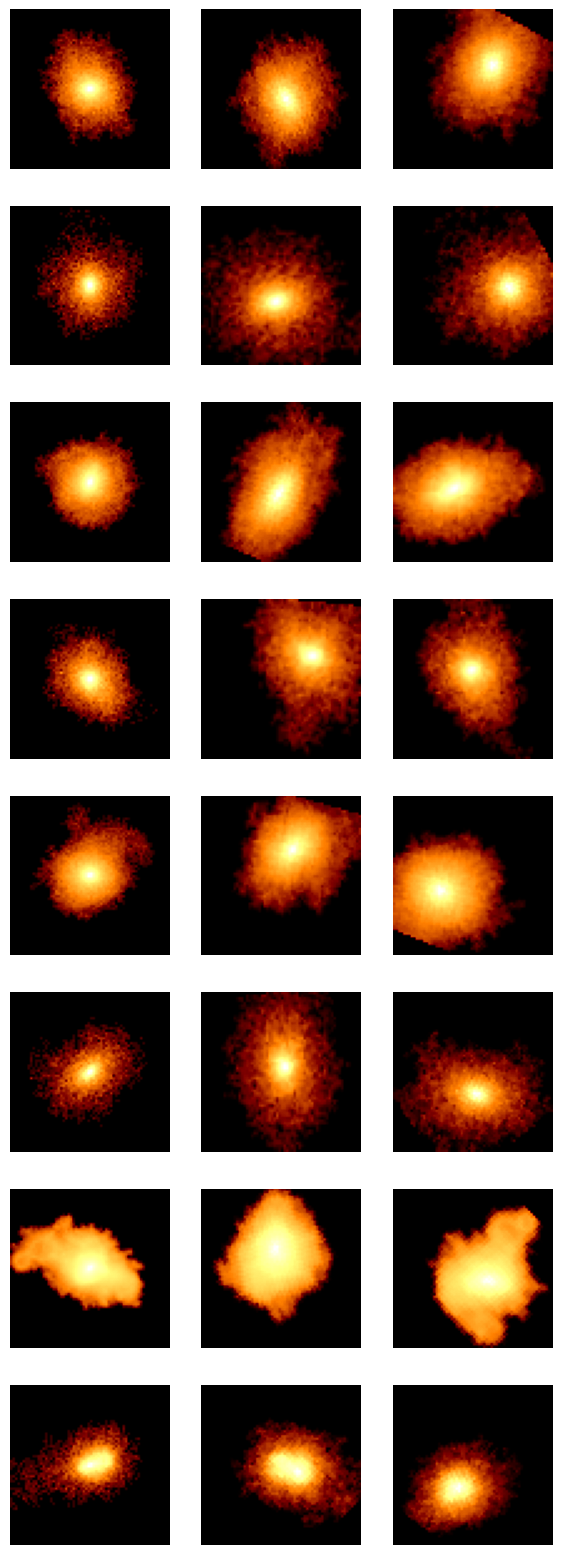

In [24]:
batch_data_full, batch_label = next(iter(dataloader))
batch_data = batch_data_full[1]

view1, view2 = select_views_and_transform(batch_data)
orig = batch_data[0]

fig, axs = plt.subplots(8, 3, figsize=(7, 20))

for i in range(8):
    axs[i, 0].imshow(orig[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 1].imshow(view1[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 2].imshow(view2[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

# Classification model for mass bin

## Model

In [25]:
class ClassificationNN(nn.Module):

    "Encoder network"
    def __init__(self):
        super(ClassificationNN, self).__init__()
    
        image_channels = 1
        self.cnn = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            #nn.Linear(64, 64),
            #nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        logits =  self.cnn(x)
        #make always class 0 for debugging, 9.1 on the first element and 0.1 on the rest
        #logits = torch.zeros_like(logits)+0.1
        #logits[:, 0] = 9.0
        return logits

def classification_train_step(
        epoch,
        model, 
        criterion,
        optimizer,
        scheduler,
        dataloader,
        dataloader_val,
        history=None,
        device='cpu',
        ):

    model.train()

    running_loss = 0.0

    for i, (batch_data_full, batch_label) in enumerate(dataloader):
        batch_size = batch_label[0].shape[0]

        batch_data = batch_data_full[1]
        batch_label = batch_label[1].to(device)

        view1, _ = select_views_and_transform(batch_data)
        view1 = view1.to(device)

        pred_class = model(view1)
        loss = criterion(pred_class, batch_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()

    running_loss /= len(dataloader)
    #print(f'Epoch {epoch}, loss: {running_loss}')

    if history is not None:
        history['loss'].append(running_loss)
    
    if dataloader_val is not None:
        model.eval()
        running_loss_val = 0.0
        for i, (batch_data_full, batch_label) in enumerate(dataloader_val):
            batch_size = batch_label[0].shape[0]

            batch_data = batch_data_full[1]
            batch_label = batch_label[1].to(device)

            view1, _ = select_views_and_transform(batch_data)
            view1 = view1.to(device)

            pred_class = model(view1)
            loss = criterion(pred_class, batch_label)

            running_loss_val += loss.item()
        
        running_loss_val /= len(dataloader_val)
        #print(f'Epoch {epoch}, val loss: {running_loss_val}')
    else:
        running_loss_val = None    
    
    if history is not None:
        history['val_loss'].append(running_loss_val)

    return running_loss, running_loss_val


def classification_train(epochs,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 dataloader,
                 dataloader_val,
                 history=None,
                 device = 'cpu'):

    pbar = tqdm(range(epochs))

    history = {'loss': [], 'val_loss': []} if history is None else history

    try:
        for epoch in pbar:
            loss, loss_val = classification_train_step(
                epoch,
                model, 
                criterion,
                optimizer,
                scheduler,
                dataloader,
                dataloader_val,
                history=history,
                device=device
            )
            pbar.set_postfix({'loss': loss, 'val_loss': loss_val})

    except KeyboardInterrupt:
        print('Interrupted')
    
    return history

In [29]:
print(f'Batch size: {batch_size}')

f_train = 0.5
train_size = int(f_train*len(dataset))
val_size = len(dataset) - train_size

#random split with the same distribution of classes
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#val_loader = None


lr = 5e-3

classification_model = ClassificationNN().to(device)

criterion = nn.CrossEntropyLoss(weight=mass_bins_weights.to(device)).to(device)
optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


Batch size: 128


In [30]:
#debug shapes
batch_data_full, batch_label = next(iter(dataloader))
batch_data = batch_data_full[1]

output = classification_model(batch_data[0].to(device))

print(f'Output shape: {output}')
print(f'Output shape: {output.shape}')

Output shape: tensor([[ 0.0245,  0.1120, -0.1326,  ..., -0.0815, -0.0944, -0.1644],
        [ 0.0368,  0.1037, -0.1183,  ..., -0.0784, -0.0960, -0.1642],
        [ 0.0290,  0.1163, -0.1227,  ..., -0.0665, -0.0911, -0.1645],
        ...,
        [ 0.0355,  0.1119, -0.1289,  ..., -0.0695, -0.0991, -0.1672],
        [ 0.0339,  0.1174, -0.1188,  ..., -0.0703, -0.0904, -0.1718],
        [ 0.0297,  0.1185, -0.1114,  ..., -0.0704, -0.0950, -0.1752]],
       grad_fn=<AddmmBackward0>)
Output shape: torch.Size([128, 10])


## Training

In [31]:
n_epochs = 5

history = classification_train(n_epochs, 
                       classification_model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=dataloader,
                        dataloader_val=val_loader,
                        device=device)


100%|██████████| 5/5 [02:28<00:00, 29.62s/it, loss=2.25, val_loss=2.26]


In [32]:
history

{'loss': [2.2784442057976357,
  2.2458451967972977,
  2.247724402867831,
  2.246492439049941,
  2.248596847974337],
 'val_loss': [2.2651819852682262,
  2.2700415501227744,
  2.263438719969529,
  2.267569087101863,
  2.262405494543222]}

---